In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import csv
import time

In [ ]:
import csv

# Load the Dataset
text = ""
file_path = "/content/poems-100.csv"  # Adjust this if needed

with open(file_path, "r") as file:
    reader = csv.reader(file)
    for row in reader:
        text += " ".join(row) + " "

In [ ]:
# Tokenize the Text into Words
tokens = text.split()

In [ ]:
# Create a Dictionary to Map Words to Indices
word_to_idx = {}
idx_to_word = {}
vocab_size = 0

for word in tokens:
    if word not in word_to_idx:
        word_to_idx[word] = vocab_size
        idx_to_word[vocab_size] = word
        vocab_size += 1

In [ ]:
# Convert Tokens to Indices
token_indices = [word_to_idx[word] for word in tokens]

In [ ]:
# Create Sequences and Targets
seq_length = 10
sequences = []
targets = []

for i in range(len(token_indices) - seq_length):
    seq = token_indices[i:i + seq_length]
    target = token_indices[i + seq_length]
    sequences.append(seq)
    targets.append(target)

In [ ]:
# Convert to PyTorch Tensors
sequences = torch.tensor(sequences, dtype = torch.long)
targets = torch.tensor(targets, dtype = torch.long)

In [ ]:
# Define One-Hot Encoding for RNN Model
class OneHotRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, output_dim):
        super(OneHotRNN, self).__init__()
        self.rnn = nn.RNN(vocab_size, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.rnn(x)
        out = self.fc(output[:, -1, :])
        return out

In [ ]:
# Define LSTM Model with Embedding Layer
class PoemLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(PoemLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        out = self.fc(output[:, -1, :])
        return out

In [ ]:
# Hyperparameters
embed_dim = 100
hidden_dim = 128
output_dim = vocab_size

In [ ]:
# Initialize Models
onehot_model = OneHotRNN(vocab_size, hidden_dim, output_dim)
embedding_model = PoemLSTM(vocab_size, embed_dim, hidden_dim, output_dim)

In [ ]:
criterion = nn.CrossEntropyLoss()
onehot_optimizer = optim.Adam(onehot_model.parameters(), lr = 0.001)
embedding_optimizer = optim.Adam(embedding_model.parameters(), lr = 0.001)

In [ ]:
# Loss Tracking
onehot_losses, embedding_losses = [], []

In [ ]:
# Training Function with Tracking
def train_model(model, optimizer, name):
    start_time = time.time()
    for epoch in range(100):
        total_loss = 0
        for i in range(0, len(sequences), 32):
            batch_seq = sequences[i:i + 32]
            batch_target = targets[i:i + 32]

            # One-Hot Encoding for OneHotRNN
            if name == "OneHotRNN":
                batch_seq = F.one_hot(batch_seq, num_classes = vocab_size).float()

            # Forward Pass
            outputs = model(batch_seq)
            loss = criterion(outputs, batch_target)

            # Backward Pass and Optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (len(sequences) // 32)
        if name == "OneHotRNN":
            onehot_losses.append(avg_loss)
        else:
            embedding_losses.append(avg_loss)

        print(f"{name} Epoch [{epoch+1}/100], Avg Loss: {avg_loss:.4f}")
    print(f"{name} Training Time: {time.time() - start_time:.2f}s\n")

In [ ]:
# Poem Generation Function
def generate_poem(model, seed_text, num_words = 50, model_type = "EmbeddingLSTM"):
    model.eval()
    words = seed_text.split()
    with torch.no_grad():
        for _ in range(num_words):
            seq = [word_to_idx.get(word, 0) for word in words[-seq_length:]]
            seq = torch.tensor(seq, dtype = torch.long).unsqueeze(0)

            if model_type == "OneHotRNN":
                seq = F.one_hot(seq, num_classes = vocab_size).float()

            output = model(seq)
            probabilities = F.softmax(output, dim = 1)
            predicted_idx = torch.multinomial(probabilities, 1).item()

            words.append(idx_to_word[predicted_idx])

    return " ".join(words)

In [ ]:
# Train Models
train_model(onehot_model, onehot_optimizer, "OneHotRNN")
train_model(embedding_model, embedding_optimizer, "EmbeddingLSTM")

OneHotRNN Epoch [1/100], Avg Loss: 7.5809
OneHotRNN Epoch [2/100], Avg Loss: 6.6965
OneHotRNN Epoch [3/100], Avg Loss: 6.3395
OneHotRNN Epoch [4/100], Avg Loss: 6.1563
OneHotRNN Epoch [5/100], Avg Loss: 5.9387
OneHotRNN Epoch [6/100], Avg Loss: 5.7972
OneHotRNN Epoch [7/100], Avg Loss: 5.6211
OneHotRNN Epoch [8/100], Avg Loss: 5.3685
OneHotRNN Epoch [9/100], Avg Loss: 5.1312
OneHotRNN Epoch [10/100], Avg Loss: 4.9061
OneHotRNN Epoch [11/100], Avg Loss: 4.6794
OneHotRNN Epoch [12/100], Avg Loss: 4.4024
OneHotRNN Epoch [13/100], Avg Loss: 4.1496
OneHotRNN Epoch [14/100], Avg Loss: 3.8914
OneHotRNN Epoch [15/100], Avg Loss: 3.5549
OneHotRNN Epoch [16/100], Avg Loss: 3.2254
OneHotRNN Epoch [17/100], Avg Loss: 2.9756
OneHotRNN Epoch [18/100], Avg Loss: 2.7255
OneHotRNN Epoch [19/100], Avg Loss: 2.4504
OneHotRNN Epoch [20/100], Avg Loss: 2.1931
OneHotRNN Epoch [21/100], Avg Loss: 1.9304
OneHotRNN Epoch [22/100], Avg Loss: 1.6641
OneHotRNN Epoch [23/100], Avg Loss: 1.4530
OneHotRNN Epoch [24/

In [ ]:
# Generate Poems
seed_text = "I work hard for everything"
print("\nGenerated Poem (OneHotRNN):", generate_poem(onehot_model, seed_text, model_type = "OneHotRNN"))
print("\nGenerated Poem (EmbeddingLSTM):", generate_poem(embedding_model, seed_text, model_type = "EmbeddingLSTM"))


Generated Poem (OneHotRNN): I work hard for everything The young mother you hear the whole, The cries, curses, roar, the plaudits for well-aim'd shots, The ambulanza slowly passing trailing its red drip, Workmen searching after damages, making indispensable repairs, The fall of grenades through the rent roof, the fan-shaped explosion, The whizz of limbs, heads, stone, wood, iron,

Generated Poem (EmbeddingLSTM): I work hard for everything must not give out these are not from bed and meeting They listening ears and her and accept And as he as my thrush Thou madest O perfect day: Whereon shall no man work, A fail in the same of the day,) Far from the settlements studying the print of


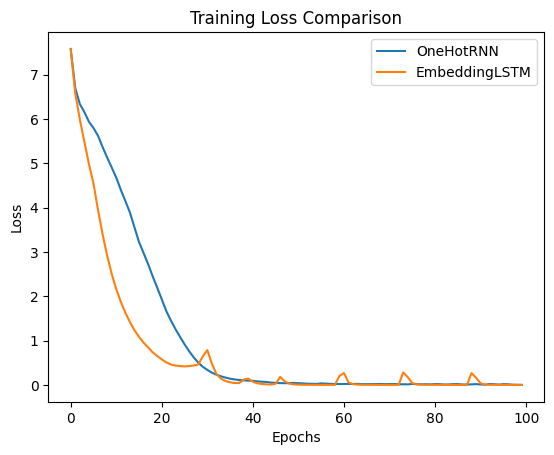

In [ ]:
import matplotlib.pyplot as plt

plt.plot(onehot_losses, label='OneHotRNN')
plt.plot(embedding_losses, label='EmbeddingLSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot Loss for OneHotRNN
plt.figure(figsize=(8, 6))
plt.plot(onehot_losses, label='OneHotRNN', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for OneHotRNN')
plt.legend()
plt.savefig('onehot_rnn_loss.png')
plt.close()

# Plot Loss for EmbeddingLSTM
plt.figure(figsize=(8, 6))
plt.plot(embedding_losses, label='EmbeddingLSTM', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for EmbeddingLSTM')
plt.legend()
plt.savefig('embedding_lstm_loss.png')
plt.close()

print("Loss plots saved successfully!")


Loss plots saved successfully!


In [ ]:
seed_text = "I work hard for everything"
onehot_poem = generate_poem(onehot_model, seed_text, model_type="OneHotRNN")
embedding_poem = generate_poem(embedding_model, seed_text, model_type="EmbeddingLSTM")

with open('generated_poems.txt', 'w') as f:
    f.write("Generated Poem (OneHotRNN):\n")
    f.write(onehot_poem + "\n\n")
    f.write("Generated Poem (EmbeddingLSTM):\n")
    f.write(embedding_poem + "\n")
